In [1]:
# Pandas & Numpy
import pandas as pd, numpy as np

# import the training and holdout data
train = pd.read_csv('../input/train.csv')
holdout = pd.read_csv('../input/test.csv')

PassengerId = train['PassengerId']
data_raw = train.append(holdout, sort = False)

In [2]:
# something for later
def clean_categorical(data, dirty_categorical, values_desired):
    for i in dirty_categorical:
        appender = []
        for j in np.array(data[i]).astype(str):           
                if j[0] in values_desired: appender.append(1)
                else: appender.append(0)
        var1 = str(i) + '_notnull'
        data[var1] = appender
    
        appender=[]   
        for j in np.array(data[i]).astype(str):
            if j == 'nan':
                appender.append('None')
            elif [j][0][0] in values_desired:
                appender.append([j][0][0])
            else: appender.append('Other')
        var2 = str(i) + '_clean'
        data[var2] = appender
        

In [3]:
# feature engineering

data = data_raw.copy()

#Fare
data['Fare_update_dummy'] = 0
data.loc[(data['Fare'] == 0), 'Fare_update_dummy'] = 1
data.loc[(data['Fare'] == 0) & (data['Pclass'] == 1), 'Fare'] = 87.508992
data.loc[(data['Fare'] == 0) & (data['Pclass'] == 2), 'Fare'] = 21.179196
data.loc[(data['Fare'] == 0) & (data['Pclass'] == 3), 'Fare'] = 13.302889

# Find the NULL and Plug it
data[data['Fare'].isnull()].index.tolist()
data.loc[(data['PassengerId'] == 1044), 'Fare'] = 13.302889

#Fare, Embarked
for i in ('Fare', 'Embarked'):
    data[i].fillna(data[i].mode()[0], inplace=True)

#family size
data['Family'] = data['SibSp'] + data['Parch'] + 1 

#Cabin
clean_categorical(data, ['Cabin'], ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'T'])
cabin_array = np.array(data['Cabin']).astype(str)
cabin_count = []
for i in cabin_array:
    if (i == 'None'):
        cabin_count.append(0)
    elif (len(i) in (2,3,4)): 
        cabin_count.append(1)
    elif (len(i) in (5,6,7,8,9)):
        cabin_count.append(2)
    else: cabin_count.append(3)
        
data['no_cabins'] = cabin_count

#Name

import re
def get_title(name):
    title_search = re.search(' ([A-Za-z]+)\.', name)
    # If the title exists, extract and return it.
    if title_search:
        return title_search.group(1)
    return ""

data['Title'] = data['Name'].apply(get_title)
# Group all non-common titles into one single grouping "Rare"
data['Title'] = data['Title'].replace(['Lady', 'Countess','Capt', 'Col','Don', 'Dr', 'Major', 'Rev', 'Sir', 'Jonkheer', 'Dona'], 'Rare')
data['Title'] = data['Title'].replace('Mlle', 'Miss')
data['Title'] = data['Title'].replace('Ms', 'Miss')
data['Title'] = data['Title'].replace('Mme', 'Mrs')
data['Title'] = data['Title'].fillna('None')
data['Name_length'] = data['Name'].str.len() 

# Ticket
data['Ticket_length'] = data['Ticket'].str.len() 

# haracter Types
data['woman_child'] = 0
data.loc[(data['Sex'] == 'female') | (data['Age'] < 15), 'woman_child'] = 1

data['rich_old_man'] = 0
data.loc[(data['Sex'] == 'male') & (data['Age'] > 45) & (data['Pclass'] == 1), 'rich_old_man'] = 1

data['poor_young_man'] = 0
data.loc[(data['Sex'] == 'male') & (data['Age'] > 20) & (data['Age'] < 30) & (data['Pclass'] == 3), 'poor_young_man'] = 1

data['alone_man'] = 0
data.loc[(data['Sex'] == 'male') & (data['Family'] == 1), 'alone_man'] = 1

data['alone_woman'] = 0
data.loc[(data['Sex'] == 'female') & (data['Family'] == 1), 'alone_woman'] = 1

list2 = ['E', 'D', 'B']
data['man_close_to_escape'] = 0
data.loc[(data['Sex'] == 'M') & (data['Cabin_clean'].isin(list2)), 'man_close_to_escape'] = 1

In [4]:
# preprocessing
data_new = data.drop(['Name', 'Ticket', 'Cabin', 'Survived'], axis = 1)

age_train = data_new[data['Age'].notna()]
age_test = data_new[data['Age'].isnull()]

print('Dimensions of training data are: ', age_train.shape)
print('Dimensions of prediction data are: ', age_test.shape)

X = age_train.drop(['Age', 'PassengerId'], axis =1)
y = age_train['Age']
Z = age_test.drop(['Age','PassengerId'], axis=1)

Dimensions of training data are:  (1046, 22)
Dimensions of prediction data are:  (263, 22)


In [5]:
# check NULLs
for i in X.columns: 
  print('The total number of null values in', i, str(X[i].isnull().sum().sum()))

The total number of null values in Pclass 0
The total number of null values in Sex 0
The total number of null values in SibSp 0
The total number of null values in Parch 0
The total number of null values in Fare 0
The total number of null values in Embarked 0
The total number of null values in Fare_update_dummy 0
The total number of null values in Family 0
The total number of null values in Cabin_notnull 0
The total number of null values in Cabin_clean 0
The total number of null values in no_cabins 0
The total number of null values in Title 0
The total number of null values in Name_length 0
The total number of null values in Ticket_length 0
The total number of null values in woman_child 0
The total number of null values in rich_old_man 0
The total number of null values in poor_young_man 0
The total number of null values in alone_man 0
The total number of null values in alone_woman 0
The total number of null values in man_close_to_escape 0


0:	learn: 32.3530479	test: 32.3410988	best: 32.3410988 (0)	total: 171ms	remaining: 34s
1:	learn: 31.5747020	test: 31.5611145	best: 31.5611145 (1)	total: 237ms	remaining: 23.5s
2:	learn: 30.8255246	test: 30.8176576	best: 30.8176576 (2)	total: 306ms	remaining: 20.1s
3:	learn: 30.0896971	test: 30.0837522	best: 30.0837522 (3)	total: 370ms	remaining: 18.1s
4:	learn: 29.3743403	test: 29.3726959	best: 29.3726959 (4)	total: 424ms	remaining: 16.6s
5:	learn: 28.6839610	test: 28.6707236	best: 28.6707236 (5)	total: 496ms	remaining: 16s
6:	learn: 28.0067260	test: 27.9973336	best: 27.9973336 (6)	total: 552ms	remaining: 15.2s
7:	learn: 27.3505172	test: 27.3404844	best: 27.3404844 (7)	total: 612ms	remaining: 14.7s
8:	learn: 26.7124976	test: 26.7053916	best: 26.7053916 (8)	total: 664ms	remaining: 14.1s
9:	learn: 26.1036556	test: 26.0982728	best: 26.0982728 (9)	total: 715ms	remaining: 13.6s
10:	learn: 25.5070389	test: 25.5078042	best: 25.5078042 (10)	total: 779ms	remaining: 13.4s
11:	learn: 24.9379667	t

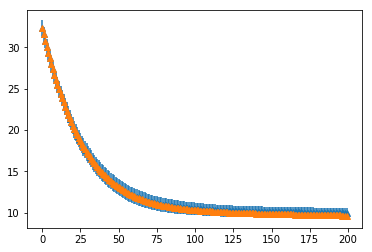

In [6]:
# Running Catboost Cross validation, to minimize RMSE
from catboost import Pool, CatBoostRegressor, CatBoostClassifier, cv

#categoricals = np.where(X.dtypes == 'object')[0]
#categoricals = np.where(Z.dtypes == 'object')[0]

train_pool = Pool(X, y, cat_features = [1,5,9, 11,13])
test_pool = Pool(Z, cat_features = [1,5,9, 11,13])

import matplotlib.pyplot as plt

# initial crossvalidation 
params= { 'iterations':200, 'eval_metric':'RMSE', 'depth':6}
scoresdict = cv(pool=train_pool,
            params=params, 
            fold_count=5, 
            inverted=False,
            partition_random_seed=0,
            shuffle=True)
# Plot test and training errors - find optimal iterations
scorespd = pd.DataFrame(scoresdict)
scorespd['iteration_no'] = list(scorespd.index.values) 
plt.errorbar(scorespd['iteration_no'], scorespd['test-RMSE-mean'], scorespd['test-RMSE-std'], linestyle='None', marker='^')
plt.errorbar(scorespd['iteration_no'], scorespd['train-RMSE-mean'], scorespd['train-RMSE-std'], linestyle='None', marker='^')
plt.show()

In [7]:
# fit best model
model = CatBoostRegressor(iterations=200, eval_metric='RMSE', depth=6, verbose = 100)
model.fit(train_pool)
Y_pred = model.predict(test_pool)

0:	learn: 32.3535602	total: 2.88ms	remaining: 572ms
100:	learn: 10.1566779	total: 316ms	remaining: 310ms
199:	learn: 9.2965738	total: 649ms	remaining: 0us


In [8]:
# Predict Age of Passengers and plug the NULLs
fill = np.array(Y_pred)
age_test['Age'] = fill
fill2 = pd.DataFrame(age_test[['Age','PassengerId']])
data = data.set_index("PassengerId").combine_first(fill2.set_index("PassengerId")).reset_index()
print('The total number of null values in Age:', str(data['Age'].isnull().sum()))

The total number of null values in Age: 0


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [9]:
# Final preprocessing
data_new2 = data.drop(['Name', 'Ticket', 'Cabin'], axis = 1)
train_ready = data_new2.loc[data_new2['PassengerId'] <= 891]
holdout_ready = data_new2.loc[data_new2['PassengerId'] > 891]

X = train_ready.drop(['PassengerId', 'Survived'], axis =1)
y = train_ready['Survived']
Z = holdout_ready.drop(['Survived'], axis = 1)

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, train_size = 0.8, random_state=42)
categoricals = np.where(X_train.dtypes == 'object')[0]

In [10]:
# CATBOOST, LIGHTGBM, XGBOOST MODEL TRAINING

In [11]:
#For Random Search Results
def report(results, n_top=3):
    for i in range(1, n_top + 1):
        candidates = np.flatnonzero(results['rank_test_score'] == i)
        for candidate in candidates:
            print("Model with rank: {0}".format(i))
            print("Mean validation score: {0:.3f} (std: {1:.3f})".format(
                  results['mean_test_score'][candidate],
                  results['std_test_score'][candidate]))
            print("Parameters: {0}".format(results['params'][candidate]))
            print("")

In [12]:
# CATBOOST DATA
from catboost import Pool, CatBoostClassifier

train_pool = Pool(X_train, y_train, cat_features = categoricals)
test_pool = Pool(X_test, y_test, cat_features = categoricals)

In [13]:
# CATBOOST PARAMS
from catboost import Pool, CatBoostClassifier


params = {
    'depth':6, 'eval_metric':'Accuracy', 'iterations':3000, 'class_weights':[1,1], 'verbose':True, 'od_type':'Iter', 'od_wait':500, 'learning_rate':0.05, 'random_seed':5,
    'bagging_temperature':0, 'l2_leaf_reg':0
}

# To be run after Random Search Module
params.update(cat_model_rs.best_params_)
cat_model = CatBoostClassifier(**params)

NameError: name 'cat_model_rs' is not defined

In [14]:
# CATBOOST TRAIN

cat_model.fit(
    train_pool,
    cat_features = None,
    eval_set = test_pool, 
    use_best_model = True, 
    verbose = 500
    )

NameError: name 'cat_model' is not defined

In [15]:
# CATBOOST RANDOM SEARCH

from catboost import CatBoostClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

#Parameters
cat_param_fixed = {'cat_features':categoricals, 
                   'eval_set':test_pool}

cat_param_grid =  {'depth': sp_randint(3,7),
                   'learning_rate': sp_uniform(loc=0.05, scale=0.05),
                   'class_weights': [[1,1],[1,1.25],[1,1.5]],
                   'bagging_temperature': sp_uniform(loc=0.5, scale=0.5),
                   'l2_leaf_reg': sp_uniform(loc=0.5, scale=0.5)
                  }
random_search_iterations = 60

cat_model = CatBoostClassifier(border_count=255, 
                              random_seed=42, 
                              verbose=True,
                              eval_metric='Accuracy',
                              iterations=300,
                              learning_rate=0.05,
                              od_type='Iter',
                              od_wait=30,
                              use_best_model=True)

cat_model_rs = RandomizedSearchCV(estimator=cat_model,
                                  param_distributions=cat_param_grid,
                                  n_iter=random_search_iterations,
                                  scoring='accuracy',
                                  cv=ShuffleSplit(test_size=0.20, n_splits=1, random_state=42),
                                  refit=True,
                                  random_state=42,
                                  verbose=True)

cat_model_rs.fit(X_train, y_train, **cat_param_fixed)
print('Best score reached: {} with params: {} '.format(cat_model_rs.best_score_, cat_model_rs.best_params_))
report(cat_model_rs.cv_results_)

Fitting 1 folds for each of 60 candidates, totalling 60 fits
0:	learn: 0.8172232	test: 0.7765363	best: 0.7765363 (0)	total: 11.9ms	remaining: 3.57s
1:	learn: 0.8224956	test: 0.7988827	best: 0.7988827 (1)	total: 18.6ms	remaining: 2.77s
2:	learn: 0.8295255	test: 0.7988827	best: 0.7988827 (1)	total: 25.7ms	remaining: 2.54s
3:	learn: 0.8347979	test: 0.8044693	best: 0.8044693 (3)	total: 32.6ms	remaining: 2.41s
4:	learn: 0.8400703	test: 0.7988827	best: 0.8044693 (3)	total: 39ms	remaining: 2.3s
5:	learn: 0.8383128	test: 0.8044693	best: 0.8044693 (3)	total: 45.2ms	remaining: 2.22s
6:	learn: 0.8400703	test: 0.8100559	best: 0.8100559 (6)	total: 51.4ms	remaining: 2.15s
7:	learn: 0.8383128	test: 0.8100559	best: 0.8100559 (6)	total: 57.7ms	remaining: 2.11s
8:	learn: 0.8400703	test: 0.8100559	best: 0.8100559 (6)	total: 63.6ms	remaining: 2.06s
9:	learn: 0.8400703	test: 0.8044693	best: 0.8100559 (6)	total: 70.5ms	remaining: 2.04s
10:	learn: 0.8435852	test: 0.8100559	best: 0.8100559 (6)	total: 76.7ms	r

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


26:	learn: 0.8558875	test: 0.8156425	best: 0.8212291 (25)	total: 176ms	remaining: 1.77s
27:	learn: 0.8558875	test: 0.8212291	best: 0.8212291 (25)	total: 182ms	remaining: 1.77s
28:	learn: 0.8558875	test: 0.8156425	best: 0.8212291 (25)	total: 188ms	remaining: 1.75s
29:	learn: 0.8541301	test: 0.8100559	best: 0.8212291 (25)	total: 194ms	remaining: 1.75s
30:	learn: 0.8541301	test: 0.8156425	best: 0.8212291 (25)	total: 201ms	remaining: 1.74s
31:	learn: 0.8558875	test: 0.8156425	best: 0.8212291 (25)	total: 207ms	remaining: 1.73s
32:	learn: 0.8558875	test: 0.8156425	best: 0.8212291 (25)	total: 213ms	remaining: 1.72s
33:	learn: 0.8558875	test: 0.8156425	best: 0.8212291 (25)	total: 221ms	remaining: 1.73s
34:	learn: 0.8576450	test: 0.8156425	best: 0.8212291 (25)	total: 228ms	remaining: 1.72s
35:	learn: 0.8594025	test: 0.8156425	best: 0.8212291 (25)	total: 234ms	remaining: 1.71s
36:	learn: 0.8594025	test: 0.8156425	best: 0.8212291 (25)	total: 240ms	remaining: 1.7s
37:	learn: 0.8594025	test: 0.8156

[Parallel(n_jobs=1)]: Done  60 out of  60 | elapsed:   22.7s finished


15:	learn: 0.8483146	test: 0.8156425	best: 0.8156425 (4)	total: 124ms	remaining: 2.2s
16:	learn: 0.8483146	test: 0.8212291	best: 0.8212291 (16)	total: 132ms	remaining: 2.2s
17:	learn: 0.8483146	test: 0.8212291	best: 0.8212291 (16)	total: 140ms	remaining: 2.2s
18:	learn: 0.8511236	test: 0.8268156	best: 0.8268156 (18)	total: 148ms	remaining: 2.19s
19:	learn: 0.8511236	test: 0.8268156	best: 0.8268156 (18)	total: 156ms	remaining: 2.19s
20:	learn: 0.8511236	test: 0.8268156	best: 0.8268156 (18)	total: 164ms	remaining: 2.18s
21:	learn: 0.8497191	test: 0.8212291	best: 0.8268156 (18)	total: 173ms	remaining: 2.18s
22:	learn: 0.8511236	test: 0.8156425	best: 0.8268156 (18)	total: 181ms	remaining: 2.19s
23:	learn: 0.8497191	test: 0.8156425	best: 0.8268156 (18)	total: 189ms	remaining: 2.18s
24:	learn: 0.8497191	test: 0.8268156	best: 0.8268156 (18)	total: 197ms	remaining: 2.17s
25:	learn: 0.8497191	test: 0.8268156	best: 0.8268156 (18)	total: 203ms	remaining: 2.14s
26:	learn: 0.8511236	test: 0.8212291

In [16]:
# LIGHTGBM DATA
cat_feat_list =  np.where(X.dtypes == 'object')[0]
import lightgbm as lgb
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature= X_train.select_dtypes('object').columns.tolist(), feature_name=X_train.columns.tolist())
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data, feature_name=X_train.columns.tolist()) 

In [17]:
X_train.

SyntaxError: invalid syntax (<ipython-input-17-1f03f83a7d9a>, line 1)

In [18]:
# LIGHTGBM PARAMS

lgb_param = { 
          # fundamental
         'boosting_type':'gbdt',
         'metric':'binary_error', # basis for model evaluation
         'objective':'binary',

         # hyperparameters
         'max_depth':-1,
         'num_leaves': 50,
         'scale_pos_weight':1, # class weights
         'learning_rate':0.005,
         'min_split_gain':0.0,
         'min_child_weight':5,
         'min_child_samples':10,
         'subsample':1,
         'subsample_freq':1,
         'colsample_bytree':1, 
         'is_unbalance':False,
            
    
         # Speed vs Quality
         'max_bin':10000, # higher for quality, lower for speed
         'subsample_for_bin':50000, 

         # Regularization
         'reg_alpha':0.0,
         'reg_lambda':0.0,
    
         # results & output format
         'verbose':0
         }

# Run after Random Search 
#lgb_param.update(lgb_model_rs.best_params_)

In [19]:
cat_feat_list = list(X_train.select_dtypes(include=['object']).columns)
cat_feature_index = np.where(X.dtypes == 'object')[0]

train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=cat_feature_index)
test_data = lgb.Dataset(X_test, label=y_test, reference=train_data)

param = {'num_trees': 4000, 'objective':'binary', 'metric': 'auc'}
bst = lgb.train(param, train_data, valid_sets=[test_data], early_stopping_rounds=100)

/opt/conda/lib/python3.6/site-packages/lightgbm/engine.py:118: UserWarning: Found `num_trees` in params. Will use it instead of argument
  warnings.warn("Found `{}` in params. Will use it instead of argument".format(alias))
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1198: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if self.categorical_feature == categorical_feature:
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1205: UserWarning: Using categorical_feature in Dataset.
  warnings.warn('Using categorical_feature in Dataset.')
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1204: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  elif categorical_feature == 'auto':
/opt/conda/lib/python3.6/site-packages/lightgbm/basic.py:1209: UserWarning: categorical_feature in Dataset is overridden.
New categoric

ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in fields Cabin_clean, Embarked, Sex, Title

In [20]:
# LIGHTGBM TRAIN
lgbm_model = lgb.train(lgb_param, train_data, num_boost_round=3000, valid_sets=test_data)

ValueError: The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()

In [21]:
# LIGHTGBM RANDOM SEARCH

import lightgbm as lgb
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

#Parameters
lgb_param_fixed = {"early_stopping_rounds":300, 
                   "eval_metric" : 'binary_error', 
                   "eval_set" : [(X_test, y_test)],
                   'eval_names': ['valid'],
                   'verbose': 100,
                   'categorical_feature': 'auto'}

lgb_param_grid =  {'num_leaves': sp_randint(30, 70), 
                   'learning_rate': sp_uniform(loc=0.05, scale=0.05),
                   'max_depth': sp_randint(3,7),
                   'min_child_weight': sp_randint(3,10),
                   'min_child_samples': sp_randint(3,10),
                   'lambda_l1': sp_uniform(loc=1, scale=1),
                   'lambda_l2': sp_uniform(loc=1, scale=1)}

random_search_iterations = 60

lgb_model = lgb.LGBMClassifier(max_bin=10000, subsample_for_bin=50000, random_state=42, silent=True, metric='accuracy', n_jobs=-1, n_estimators=3000, learning_rate=0.005)

lgb_model_rs = RandomizedSearchCV(estimator=lgb_model,
                                  param_distributions=lgb_param_grid,
                                  n_iter=random_search_iterations,
                                  scoring='accuracy',
                                  cv=ShuffleSplit(test_size=0.20, n_splits=1, random_state=42),
                                  refit=True,
                                  random_state=42,
                                  verbose=True)

lgb_model_rs.fit(X_train, y_train, **lgb_param_fixed)

print('Best score reached: {} with params: {} '.format(lgb_model_rs.best_score_, lgb_model_rs.best_params_))
report(lgb_model_rs.cv_results_)

Fitting 1 folds for each of 60 candidates, totalling 60 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.6/site-packages/sklearn/model_selection/_validation.py:528: FutureWarning: From version 0.22, errors during fit will result in a cross validation score of NaN by default. Use error_score='raise' if you want an exception raised or error_score=np.nan to adopt the behavior from version 0.22.
  FutureWarning)


ValueError: DataFrame.dtypes for data must be int, float or bool.
Did not expect the data types in fields Cabin_clean, Embarked, Sex, Title

In [22]:
# XGBOOST DATA

def create_dummies(df,column_name):
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

for column in ["Pclass", "Sex", "Title", "Embarked", "Cabin_clean"]:
    X_train_xg = create_dummies(X_train,column)
    X_test_xg = create_dummies(X_test,column)

cat_feat_list_xg = list(X_train.select_dtypes(include=['category']).columns)
    
import xgboost as xgb
dtrain = xgb.DMatrix(X_train_xg.drop(cat_feat_list_xg, axis = 1, inplace = True), label=y_train)
dtest = xgb.DMatrix(X_test_xg.drop(cat_feat_list_xg, axis = 1, inplace = True), label=y_test)
evallist = [(dtest, 'eval'), (dtrain, 'train')]

In [23]:
# XGBOOST PARAMS

params = {'max_depth':3, 'scale_pos_weight':1,
          'eval_metric':'error','silent': 1,
          'objective': 'binary:logistic',
          'early_stopping_rounds':100, 'learning_rate':0.3}
num_round=81

#params.update(xgb_model_rs.best_params_)

In [24]:
# XGBOOST TRAIN

from xgboost import XGBClassifier
xgb_model = xgb.train(params, dtrain, num_round, evallist)

XGBoostError: [06:50:54] /workspace/src/c_api/c_api.cc:837: DMatrix/Booster has not been intialized or has already been disposed.
Stack trace:
  [bt] (0) /opt/conda/xgboost/libxgboost.so(dmlc::LogMessageFatal::~LogMessageFatal()+0x24) [0x7fcc96ad0cb4]
  [bt] (1) /opt/conda/xgboost/libxgboost.so(XGDMatrixNumCol+0x5f) [0x7fcc96ac4fff]
  [bt] (2) /opt/conda/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call_unix64+0x4c) [0x7fcd036c1ec0]
  [bt] (3) /opt/conda/lib/python3.6/lib-dynload/../../libffi.so.6(ffi_call+0x22d) [0x7fcd036c187d]
  [bt] (4) /opt/conda/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(_ctypes_callproc+0x2ce) [0x7fcd038d7e5e]
  [bt] (5) /opt/conda/lib/python3.6/lib-dynload/_ctypes.cpython-36m-x86_64-linux-gnu.so(+0x13895) [0x7fcd038d8895]
  [bt] (6) /opt/conda/bin/python(_PyObject_FastCallDict+0x8b) [0x563e458fa38b]
  [bt] (7) /opt/conda/bin/python(+0x19a58e) [0x563e4598158e]
  [bt] (8) /opt/conda/bin/python(_PyEval_EvalFrameDefault+0x2fa) [0x563e459a5a1a]



In [25]:
# XGBOOST RANDOM SEARCH

from xgboost import XGBClassifier
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform as sp_uniform

#Parameters
xgb_param_fixed = {}

xgb_param_grid =  {'max_depth': sp_randint(3,7),
                   'learning_rate': sp_uniform(loc=0.05, scale=0.05)
                   'scale_pos_weight': sp_uniform(loc=1.25, scale=0.25),
                   'min_child_weight': sp_randint(0,20),
                   'gamma': sp_uniform(loc=0.5, scale=0.5),
                   'reg_lambda': sp_uniform(loc=0.5, scale=0.5),
                   'reg_lambda': sp_uniform(loc=0.5, scale=0.5)}

random_search_iterations = 60

xgb_model = xgb.XGBClassifier(max_bin=5000, subsample_for_bin=50000, 
                              seed=42, silent=False,
                              metric='accuracy', n_jobs=-1, 
                              n_estimators=10, 
                              learning_rate=0.005,
                              early_stopping_rounds = 30)

xgb_model_rs = RandomizedSearchCV(estimator=xgb_model,
                                  param_distributions=xgb_param_grid,
                                  n_iter=random_search_iterations,
                                  scoring='accuracy',
                                  cv=ShuffleSplit(test_size=0.20, n_splits=1, random_state=42),
                                  refit=True,
                                  random_state=42,
                                  verbose=True)

xgb_model_rs.fit(X_train_xg, y_train, **xgb_param_fixed)
print('Best score reached: {} with params: {} '.format(xgb_model_rs.best_score_, xgb_model_rs.best_params_))
report(xgb_model_rs.cv_results_)

SyntaxError: invalid syntax (<ipython-input-25-b720c295a396>, line 14)

In [26]:
# LIGHTGBM - CATBOOST - XGBOOST MODEL EVALUATION

In [27]:
# CAT PREDICTIONS
cat_predictions_probs = cat_model.predict_proba(test_pool)
cat_predictions = cat_model.predict(test_pool)
#cat_predictions = np.where(cat_predictions_probs[:,1] > 0.47, 1, 0)
print(cat_predictions[:5]) # predicted class
print(cat_predictions_probs[:5]) # probability scores

CatBoostError: There is no trained model to use predict_proba(). Use fit() to train model. Then use this method.

In [28]:
# CAT MODEL EVALUATION

print('CAT MODEL EVALUATION')
print(y.describe())
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
print('\nAccuracy: ', str(accuracy_score(y_test, cat_predictions)))
print('Precision: ', str(precision_score(y_test, cat_predictions)))
print('Recall: ', str(recall_score(y_test, cat_predictions)))
print('F1: ', str(f1_score(y_test, cat_predictions)))
print('Area under ROC Curve: ', str(roc_auc_score(y_test, cat_predictions_probs[:,1])))
print('GINI: ', str(-1 + 2*roc_auc_score(y_test, cat_predictions_probs[:,1])))

tn, fp, fn, tp = confusion_matrix(y_test, cat_predictions).ravel()

print('True Negatives: ', str(tn))
print('True Positives: ', str(tp))
print('False Negatives: ', str(fn))
print('False Positives: ', str(fp))

CAT MODEL EVALUATION
count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64


NameError: name 'cat_predictions' is not defined

In [29]:
#CAT FEATURE IMPORTANCE

feature_importance = cat_model.get_feature_importance(train_pool)
feature_names = X_train.columns
feature_imp = pd.DataFrame([feature_names, feature_importance])
final = feature_imp.transpose()
final.sort_values(by = 1, ascending = False, inplace = True)
pd.set_option('display.max_colwidth', -1)
final.head(500)

CatBoostError: catboost/libs/fstr/calc_fstr.cpp:697: Model is not trained

In [30]:
# LIGHT PREDICTIONS
lgbm_predictions_probs = lgbm_model.predict(X_test, num_iteration=lgbm_model.best_iteration)
lgbm_predictions = np.where(lgbm_predictions_probs > 0.50, 1, 0)
print('First 5 Predictions: ', lgbm_predictions[:5])
print('First 5 Probability Scores: ', '\n', lgbm_predictions_probs[:5], '\n')

NameError: name 'lgbm_model' is not defined

In [31]:
# LIGHT MODEL EVALUATION

print('LIGHT GBM MODEL EVALUATION')
print('\nSummary Stats on Y\n')
print(y.describe())
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
print('\nAccuracy: ', str(accuracy_score(y_test, lgbm_predictions)))
print('Precision: ', str(precision_score(y_test, lgbm_predictions)))
print('Recall: ', str(recall_score(y_test, lgbm_predictions)))
print('F1: ', str(f1_score(y_test, lgbm_predictions)))
print('Area under ROC Curve: ', str(roc_auc_score(y_test, lgbm_predictions_probs)))
print('GINI: ', str(-1 + 2*roc_auc_score(y_test, lgbm_predictions_probs)), '\n')

tn, fp, fn, tp = confusion_matrix(y_test, lgbm_predictions).ravel()

print('True Negatives: ', str(tn))
print('True Positives: ', str(tp))
print('False Negatives: ', str(fn))
print('False Positives: ', str(fp))


LIGHT GBM MODEL EVALUATION

Summary Stats on Y

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64


NameError: name 'lgbm_predictions' is not defined

In [32]:
# LIGHT FEATURES IMPORTANCE
feature_importance_splits = pd.DataFrame([X.columns, lgbm_model.feature_importance(importance_type='split')]).transpose()
feature_importance_splits.columns = ['Feature', 'Importance_by_Split']
feature_importance_splits.sort_values(by='Importance_by_Split', axis=0, ascending=False, inplace=True, na_position='last')

feature_importance_gain = pd.DataFrame([X.columns, lgbm_model.feature_importance(importance_type='gain')]).transpose()
feature_importance_gain.columns = ['Feature', 'Importance_by_Gain']
feature_importance_gain.sort_values(by='Importance_by_Gain', axis=0, ascending=False, inplace=True, na_position='last')

no_of_rows = 1000
pd.set_option('display.max_rows', no_of_rows)
pd.set_option('display.max_colwidth', -1)
feature_importance_gain.head(30)

NameError: name 'lgbm_model' is not defined

In [33]:
# XGBOOST PREDICTIONS
xgb_predictions_probs = xgb_model.predict(dtest, ntree_limit=xgb_model.best_ntree_limit)
xgb_predictions = np.where(xgb_predictions_probs > 0.5, 1, 0)
print(xgb_predictions[:5]) # predicted class
print(xgb_predictions_probs[:5]) # probability scores

NameError: name 'xgb_model' is not defined

In [34]:
# XGBOOST MODEL EVALUATION

print('XGBOOST MODEL EVALUATION')
print('\nSummary Stats on Y\n')
print(y.describe())
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
print('\nAccuracy: ', str(accuracy_score(y_test, xgb_predictions)))
print('Precision: ', str(precision_score(y_test, xgb_predictions)))
print('Recall: ', str(recall_score(y_test, xgb_predictions)))
print('F1: ', str(f1_score(y_test, xgb_predictions)))
print('Area under ROC Curve: ', str(roc_auc_score(y_test, xgb_predictions_probs)))
print('GINI: ', str(-1 + 2*roc_auc_score(y_test, xgb_predictions_probs)), '\n')

tn, fp, fn, tp = confusion_matrix(y_test, xgb_predictions).ravel()

print('True Negatives: ', str(tn))
print('True Positives: ', str(tp))
print('False Negatives: ', str(fn))
print('False Positives: ', str(fp))

XGBOOST MODEL EVALUATION

Summary Stats on Y

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64


NameError: name 'xgb_predictions' is not defined

In [35]:
# XG FEATURES IMPORTANCE
feature_importance_splits = pd.DataFrame(list(xgb_model.get_score(importance_type='weight').items()), columns=['feature','importance']).sort_values('importance', ascending=False)
feature_importance_splits.columns = ['Feature', 'Importance_by_Split']
feature_importance_splits.sort_values(by='Importance_by_Split', axis=0, ascending=False, inplace=True, na_position='last')

feature_importance_gain = pd.DataFrame(list(xgb_model.get_score(importance_type='gain').items()), columns=['feature','importance']).sort_values('importance', ascending=False)
feature_importance_gain.columns = ['Feature', 'Importance_by_Avg_Gain_per_Split']
feature_importance_gain.sort_values(by='Importance_by_Avg_Gain_per_Split', axis=0, ascending=False, inplace=True, na_position='last')

no_of_rows = 1000
pd.set_option('display.max_rows', no_of_rows)
pd.set_option('display.max_colwidth', -1)
feature_importance_gain.head(30)

NameError: name 'xgb_model' is not defined

In [36]:
# ENSEMBLE PREDICTIONS (AVERAGE)

common_predictions = pd.DataFrame()

# combine predictions
common_predictions['lgbm_class'] = lgbm_predictions
common_predictions['lgbm_prob'] = lgbm_predictions_probs
common_predictions['cat_class'] = cat_predictions
common_predictions['cat_prob'] = cat_predictions_probs[:,1]
common_predictions['xgb_class'] = xgb_predictions
common_predictions['xgb_prob'] = xgb_predictions_probs
common_predictions['y'] = y_test

correlation1 = common_predictions[['lgbm_class', 'cat_class', 'xgb_class']].corr(method='pearson')
correlation2 = common_predictions[['lgbm_prob', 'cat_prob', 'xgb_prob']].corr(method='pearson')

print(correlation1)
print(correlation2)

ensemble_predictions = common_predictions[["lgbm_class", "cat_class", "xgb_class"]].mode(axis=1) # majority vote
ensemble_predictions_probs = common_predictions[["lgbm_prob", "cat_prob", "xgb_prob"]].mean(axis=1) # simple average

NameError: name 'lgbm_predictions' is not defined

In [37]:
# ENSEMBLE CLASS PREDICTION EVALUATION

print('ENSEMBLE EVALUATION')
print('\nSummary Stats on Y\n')
print(y.describe())
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, roc_curve, auc
print('\nAccuracy: ', str(accuracy_score(y_test, ensemble_predictions)))
print('Precision: ', str(precision_score(y_test, ensemble_predictions)))
print('Recall: ', str(recall_score(y_test, ensemble_predictions)))
print('F1: ', str(f1_score(y_test, ensemble_predictions)))

tn, fp, fn, tp = confusion_matrix(y_test, ensemble_predictions).ravel()

print('True Negatives: ', str(tn))
print('True Positives: ', str(tp))
print('False Negatives: ', str(fn))
print('False Positives: ', str(fp))

print('Area under ROC Curve: ', str(roc_auc_score(y_test, ensemble_predictions_probs)))
print('GINI: ', str(-1 + 2*roc_auc_score(y_test, ensemble_predictions_probs)), '\n')

ENSEMBLE EVALUATION

Summary Stats on Y

count    891.000000
mean       0.383838
std        0.486592
min        0.000000
25%        0.000000
50%        0.000000
75%        1.000000
max        1.000000
Name: Survived, dtype: float64


Exception ignored in: <bound method Booster.__del__ of <xgboost.core.Booster object at 0x7fccbd02e6d8>>
Traceback (most recent call last):
  File "/opt/conda/lib/python3.6/site-packages/xgboost/core.py", line 957, in __del__
    if self.handle is not None:
AttributeError: 'Booster' object has no attribute 'handle'


NameError: name 'ensemble_predictions' is not defined